In [1]:
import numpy as np
import b18_routines as b18
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Math

In [2]:
verbose = 1
%config Completer.use_jedi = False  #Speeds up tab autocomplete in notebooks

In [3]:
# Set up input parameters that will be fixed throughout
a, b, c = 0.1  ,-14054, 0.0 # Dissociation   #TABLE S2 of B18
a, b, c = -1.98, -4402, 0.0 # Exchange

#2 sets of values for dissolution from '16 and '18 papers
a_Mg_B16, b_Mg_B16, c_Mg_B16 = 1.23, -18816.0, 0.0
a_Mg_B18, b_Mg_B18, c_Mg_B18 = 1.06  ,-12842 , 0.0 # Dissolution - use this for now. 

a_Mg_OS, b_Mg_OS, c_Mg_OS = 0.1,-10851,0.0
a_Si_OS, b_Si_OS, c_Si_OS = 1.3,-13500,0.0  # Fischer 2015
a_O_OS , b_O_OS , c_O_OS  = 0.6,-3800 ,22.0 # Fischer 2015

eps_OO , eps_SiSi, eps_CC, eps_SS , eps_MgMg        = -1.0, 12.4, 12.8,-5.7, 0.0
eps_OSi, eps_OC  , eps_OS, eps_CSi, eps_SSi, eps_SC = -5.0,-20.0, -7.4, 9.7, 9.0, 6.1
eps_CMg, eps_OMg , eps_SiMg, eps_SMg                = 0.0, -21.6, 4.6, 0.0

In [10]:
# These params may want to change...
Tcmb   = np.linspace(4900,4100,101)

core_mass_fractions = [0.03, 0.03, 0]
XO_c, XSi_c, XMgO_c = b18.mass2moleconc_core(*core_mass_fractions) #Mass fractions of core O,Si,MgO in mole fractions

XS_c = 0.0000
XC_c = 0.0000
XFe_c= 1-XO_c-XSi_c-XMgO_c
XMgO_m  = 0.5
XFeO_m  = 0.1
XSiO2_m = 1.0 -  XMgO_m - XFeO_m

In [5]:
# Compare logKd values from different studies
logKd_MgO_B16 = b18.logKd_ideal(a_Mg_B16, b_Mg_B16, c_Mg_B16, Tcmb)
logKd_MgO_B18 = b18.logKd_ideal(a_Mg_B18, b_Mg_B18, c_Mg_B18, Tcmb)
logKd_MgO_O16 = b18.logKd_ideal(a_Mg_OS , b_Mg_OS , c_Mg_OS , Tcmb)

## Calculate activity coefficients ($\gamma$)

In [6]:
cO_c_niM, cSi_c_niM, cMg_c_niM = np.zeros(len(Tcmb)), np.zeros(len(Tcmb)), np.zeros(len(Tcmb))
cO_c_ni , cSi_c_ni , cMg_c_ni  = np.zeros(len(Tcmb)), np.zeros(len(Tcmb)), np.zeros(len(Tcmb))
loggammaO, loggammaMg          = np.zeros(len(Tcmb)), np.zeros(len(Tcmb))

params, min_conc = b18.min_conc_closure()

# eps needs to be a YxY symmetric matrix containing coeffs for C, O, Si, S, Mg, ...,. 
X_C   = np.array( [XC_c   , XO_c   , XSi_c   , XS_c   , XMgO_c])
eps_C = np.array([[eps_CC , eps_OC , eps_CSi , eps_SC , eps_CMg], 
                  [eps_OC , eps_OO , eps_OSi , eps_OS , eps_OMg], 
                  [eps_CSi, eps_OSi, eps_SiSi, eps_SSi, eps_SiMg],
                  [eps_SC , eps_OS , eps_SSi , eps_SS , eps_SMg],
                  [eps_CMg, eps_OMg, eps_SiMg, eps_SMg, eps_MgMg]])

print('Input mole fractions [C, O, Si, S]: \n', X_C)
print('Input eps matrix: \n', eps_C)

lngamma0a = np.array([-0.62,     4.29, -6.65, 0.0, 0.0])
lngamma0b = np.array([-0.00, -16500.0, 0.00 , 0.0, 0.0])

T0 = 1873.0
verb = 0

tt = 0
for t in Tcmb: 
    eps = eps_C * T0 / t                                             # eqn S6
    lngamma0   = lngamma0a + lngamma0b/t
    lngamma0   = lngamma0  * (T0 / t)                                # eqn S5
    lngamma0[1]= lngamma0[1] * t/T0                                  # Do not set 
    lngammaFe  = b18.ln_gamma_Fe(X_C,eps,verb)                       # eqn S3
    lngammai   = b18.ln_gamma_i( X_C,eps, lngammaFe, lngamma0, verb) # eqn S4
    
    if verbose == 1:
        print('T = {:6.1f} gammaC0 = {:6.4f} gamma_O0 = {:6.4f} gammaSi0 = {:6.4f} gammaS0 = {:6.4f} gammaMg0 = {:6.4f}'
              .format(t,np.exp(lngamma0[0]),np.exp(lngamma0[1]),np.exp(lngamma0[2]), np.exp(lngamma0[3]), np.exp(lngamma0[4])))
        print('T = {:6.1f} gammaC  = {:6.4f} gamma_O  = {:6.4f} gammaSi  = {:6.4f} gammaS  = {:6.4f} gammaMg  = {:6.4f} gammaFe  = {:5.3f}'
          .format(t,np.exp(lngammai[0]),np.exp(lngammai[1]),np.exp(lngammai[2]), np.exp(lngammai[3]),np.exp(lngammai[4]), np.exp(lngammaFe)))

    loggammaO[tt]  = lngammai[1]/2.303
    loggammaMg[tt] = lngammai[4]/2.303
    
    res = optimize.bisect(min_conc, 0, 0.1, args=(XO_c,XSi_c,XMgO_m,eps,lngamma0,logKd_MgO_B18[tt], t))
    #res = optimize.minimize(min_conc, 0.0, args=(XO_c,XSi_c,XMgO_m,eps,lngamma0,logKd_MgO_B18[tt], t),
    #                        method='BFGS', tol=1e-3)
    
    cO_c_niM[tt], cSi_c_niM[tt], cMg_c_niM[tt] = b18.mole2massconc_core(params['X'][1], params['X'][2], params['X'][4])

    tt = tt + 1

Input mole fractions [C, O, Si, S]: 
 [0.         0.09502262 0.05429864 0.         0.        ]
Input eps matrix: 
 [[ 12.8 -20.    9.7   6.1   0. ]
 [-20.   -1.   -5.   -7.4 -21.6]
 [  9.7  -5.   12.4   9.    4.6]
 [  6.1  -7.4   9.   -5.7   0. ]
 [  0.  -21.6   4.6   0.    0. ]]
T = 4900.0 gammaC0 = 0.7890 gamma_O0 = 2.5160 gammaSi0 = 0.0787 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4900.0 gammaC  = 0.4551 gamma_O  = 2.1649 gammaSi  = 0.0843 gammaS  = 0.9192 gammaMg  = 0.4867 gammaFe  = 1.006
T = 4892.0 gammaC0 = 0.7887 gamma_O0 = 2.5021 gammaSi0 = 0.0784 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4892.0 gammaC  = 0.4546 gamma_O  = 2.1525 gammaSi  = 0.0839 gammaS  = 0.9191 gammaMg  = 0.4862 gammaFe  = 1.006
T = 4884.0 gammaC0 = 0.7884 gamma_O0 = 2.4884 gammaSi0 = 0.0781 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4884.0 gammaC  = 0.4540 gamma_O  = 2.1401 gammaSi  = 0.0836 gammaS  = 0.9190 gammaMg  = 0.4856 gammaFe  = 1.006
T = 4876.0 gammaC0 = 0.7881 gamma_O0 = 2.4746 gammaSi0 = 0.0777 gammaS0 = 

T = 4580.0 gammaC0 = 0.7760 gamma_O0 = 1.9885 gammaSi0 = 0.0659 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4580.0 gammaC  = 0.4308 gamma_O  = 1.6932 gammaSi  = 0.0709 gammaS  = 0.9138 gammaMg  = 0.4628 gammaFe  = 1.007
T = 4572.0 gammaC0 = 0.7757 gamma_O0 = 1.9760 gammaSi0 = 0.0656 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4572.0 gammaC  = 0.4301 gamma_O  = 1.6821 gammaSi  = 0.0706 gammaS  = 0.9137 gammaMg  = 0.4622 gammaFe  = 1.007
T = 4564.0 gammaC0 = 0.7754 gamma_O0 = 1.9635 gammaSi0 = 0.0653 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4564.0 gammaC  = 0.4295 gamma_O  = 1.6710 gammaSi  = 0.0703 gammaS  = 0.9136 gammaMg  = 0.4616 gammaFe  = 1.007
T = 4556.0 gammaC0 = 0.7750 gamma_O0 = 1.9511 gammaSi0 = 0.0650 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4556.0 gammaC  = 0.4289 gamma_O  = 1.6600 gammaSi  = 0.0699 gammaS  = 0.9134 gammaMg  = 0.4610 gammaFe  = 1.007
T = 4548.0 gammaC0 = 0.7747 gamma_O0 = 1.9387 gammaSi0 = 0.0647 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4548.0 gammaC  = 0.4282 gamma_O  = 1.

T = 4244.0 gammaC0 = 0.7606 gamma_O0 = 1.4950 gammaSi0 = 0.0531 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4244.0 gammaC  = 0.4030 gamma_O  = 1.2569 gammaSi  = 0.0575 gammaS  = 0.9073 gammaMg  = 0.4355 gammaFe  = 1.007
T = 4236.0 gammaC0 = 0.7602 gamma_O0 = 1.4841 gammaSi0 = 0.0528 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4236.0 gammaC  = 0.4023 gamma_O  = 1.2473 gammaSi  = 0.0572 gammaS  = 0.9072 gammaMg  = 0.4348 gammaFe  = 1.007
T = 4228.0 gammaC0 = 0.7598 gamma_O0 = 1.4732 gammaSi0 = 0.0526 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4228.0 gammaC  = 0.4016 gamma_O  = 1.2377 gammaSi  = 0.0569 gammaS  = 0.9070 gammaMg  = 0.4341 gammaFe  = 1.007
T = 4220.0 gammaC0 = 0.7594 gamma_O0 = 1.4624 gammaSi0 = 0.0523 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4220.0 gammaC  = 0.4009 gamma_O  = 1.2282 gammaSi  = 0.0566 gammaS  = 0.9068 gammaMg  = 0.4334 gammaFe  = 1.007
T = 4212.0 gammaC0 = 0.7590 gamma_O0 = 1.4515 gammaSi0 = 0.0520 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4212.0 gammaC  = 0.4002 gamma_O  = 1.

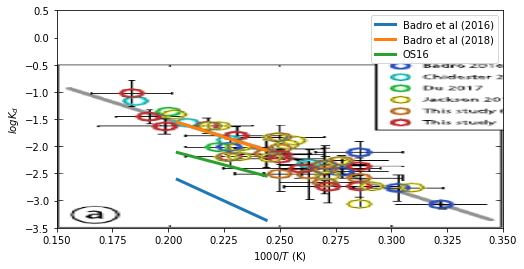

In [7]:
fig, ax1 = plt.subplots(figsize=(8,4))

fischer_a = plt.imread('Fischer_2016_fig6a.png')
fischer_b = plt.imread('Fischer_2016_fig6b.png')
#ax1.imshow(fischer_a, extent=(0.15,0.55,-5,2), aspect='auto') #Plot fischer plot below

badro_1a = plt.imread('badro_18_fig1a.png')
ax1.imshow(badro_1a, extent=(0.15,0.35,-3.5,-0.5), aspect='auto')

ax1.set_ylim([-3.5,0.5]) # Fischer Fig 6
ax1.set_xlabel("$1000/T$ (K)")
ax1.set_ylabel("$log K_d$")
ax1.set_xlim([0.15,0.35])
ax1.plot(1000.0/Tcmb, logKd_MgO_B16, lw=3, label="Badro et al (2016)")
ax1.plot(1000.0/Tcmb, logKd_MgO_B18, lw=3, label="Badro et al (2018)")
ax1.plot(1000.0/Tcmb, logKd_MgO_O16, lw=3, label="OS16")
ax1.legend()

Note that Figure 6 plots from Fischer 2016 are plotted in the background above

In [8]:
# Find the eq conc at each T for just MgO equilibrium
XMg_B16_E  = b18.Mg_exchange(XMgO_m, XFe_c, XFeO_m, 10**logKd_MgO_B16, 0.0, 0.0)
XMg_B18_E  = b18.Mg_exchange(XMgO_m, XFe_c, XFeO_m, 10**logKd_MgO_B18, 0.0, 0.0)
XMg_O16_E  = b18.Mg_exchange(XMgO_m, XFe_c, XFeO_m, 10**logKd_MgO_O16, 0.0, 0.0)
cO_c_B16_E, cSi_c_B16_E, cMg_c_B16_E = b18.mole2massconc_core(XO_c, XSi_c, XMg_B16_E)
cO_c_B18_E, cSi_c_B18_E, cMg_c_B18_E = b18.mole2massconc_core(XO_c, XSi_c, XMg_B18_E)
cO_c_O16_E, cSi_c_O16_E, cMg_c_O16_E = b18.mole2massconc_core(XO_c, XSi_c, XMg_O16_E)

XMg_B16_DC = b18.Mg_dissociation(XMgO_m, XO_c, 10**logKd_MgO_B16 , 0.0, 0.0)
XMg_B18_DC = b18.Mg_dissociation(XMgO_m, XO_c, 10**logKd_MgO_B18 , 0.0, 0.0)
XMg_O16_DC = b18.Mg_dissociation(XMgO_m, XO_c, 10**logKd_MgO_O16, 0.0, 0.0)

XMg_B16_DLi = b18.Mg_dissolution(XMgO_m, 10**logKd_MgO_B16, 0.0, 0.0)
XMg_B18_DLi = b18.Mg_dissolution(XMgO_m, 10**logKd_MgO_B18, 0.0, 0.0)
XMg_O16_DLi = b18.Mg_dissolution(XMgO_m, 10**logKd_MgO_O16, 0.0, 0.0)
cO_c_B16_DLi, cSi_c_B16_DLi, cMg_c_B16_DLi = b18.mole2massconc_core(XO_c, XSi_c, XMg_B16_DLi)
cO_c_B18_DLi, cSi_c_B18_DLi, cMg_c_B18_DLi = b18.mole2massconc_core(XO_c, XSi_c, XMg_B18_DLi)
cO_c_O16_DLi, cSi_c_O16_DLi, cMg_c_O16_DLi = b18.mole2massconc_core(XO_c, XSi_c, XMg_O16_DLi)

XMg_B18_DLni  = b18.Mg_dissolution(XMgO_m, 10**logKd_MgO_B18,loggammaO,loggammaMg)
XO_c_ni       = XMg_B18_DLni + XO_c                                         # Add O in MgO to core O 
cO_c_B18_DLni, cSi_c_B18_DLni, cMg_c_B18_DLni = b18.mole2massconc_core(XO_c_ni, XSi_c, XMg_B18_DLni)

XMg_B18_DLniMg = b18.Mg_dissolution(XMgO_m, 10**logKd_MgO_B18,loggammaO,0.0)
XO_c_niMg      =  XMg_B18_DLniMg + XO_c                                        # Add O in MgO to core O 
cO_c_B18_DLniMg, cSi_c_B18_DLniMg, cMg_c_B18_DLniMg = b18.mole2massconc_core(XO_c_ni, XSi_c, XMg_B18_DLniMg)

# Making sure we can reproduce B16 Fig 1b
XMg_B16 = b18.Mg_dissolution_B16(XMgO_m, 10**logKd_MgO_B16)
cO_c_B16, cSi_c_B16, cMg_c_B16 = b18.mole2massconc_core(0.0, 0.0, XMg_B16)

print('Tcmb        = ', Tcmb[0])
print('\nInput mole fractions:')
display(Math(r'X_O^{{metal}} = {}\\ X_{{Si}}^{{metal}} = {}\\ X_{{MgO}}^{{metal}} = {}\\ X_{{FeO}}^{{metal}} = {}'.format(XO_c, XSi_c, XMgO_c, XFe_c)))

display(Math(r'X_{{MgO}}^{{silicate}} = {}\\'.format(XMgO_m)))
print('a + b/T     = ', logKd_MgO_B18[0])
print('log_gammaO  = ', loggammaO[0])
print('log_gammaMg = ', loggammaMg[0])
display(Math(r'X_{{MgO}}^{{metal}} = {}'.format(XMg_B18_DLni[0])))
print('Which should be the same as:')
print(10**(a_Mg_B18 + b_Mg_B18/Tcmb[0] + np.log10(XMgO_m) - loggammaO[0] - loggammaMg[0]))

Tcmb        =  4900.0

Input mole fractions:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

a + b/T     =  -1.5608163265306123
log_gammaO  =  0.3353822574138986
log_gammaMg =  -0.3126612890323551


<IPython.core.display.Math object>

Which should be the same as:
0.013044658360732816


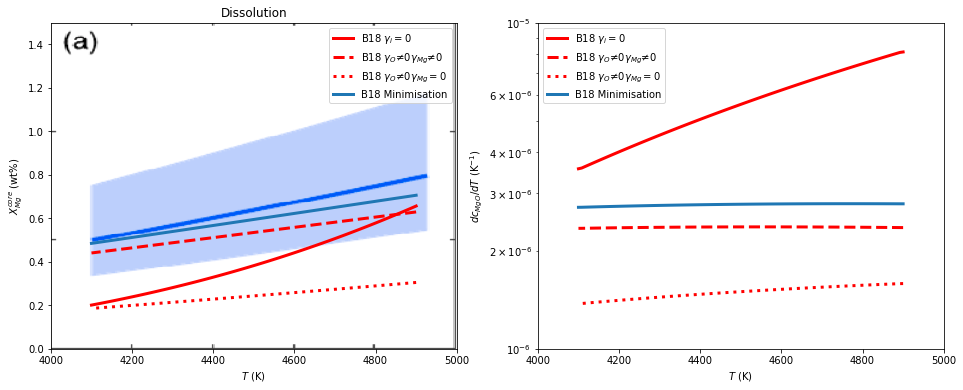

In [9]:
fig, (ax2,ax3) = plt.subplots(1,2,figsize=(16,6))

badro_4a = plt.imread('badro_18_fig4a.png')
ax2.imshow(badro_4a, extent=(4000,5000,0,1.5), aspect='auto')

ax2.set_title("Dissolution")
ax2.set_xlim([4000,5000])
ax2.set_ylim([0   ,1.5   ])
ax2.set_xlabel("$T$ (K)")
ax2.set_ylabel("$X_{Mg}^{core}$ (wt%)")
ax2.plot(Tcmb, cMg_c_B18_DLi*100   , label="B18 $\gamma_i=0$"                     , color='red', lw=3)
ax2.plot(Tcmb, cMg_c_B18_DLni*100  , label="B18 $\gamma_O\\ne0 \gamma_{Mg}\\ne0$ ", color='red',linestyle='--', lw=3)
ax2.plot(Tcmb, cMg_c_B18_DLniMg*100, label="B18 $\gamma_O\\ne0 \gamma_{Mg}=0$ "   , color='red',linestyle=':', lw=3)
ax2.plot(Tcmb, cMg_c_niM*100       , label="B18 Minimisation", lw=3)
#ax2.plot(Tcmb, cMg_c_O16_DL*100   , label="O16", color='orange', lw=3)
ax2.legend()

dT = Tcmb[1] - Tcmb[0]
dcMgdT_DLi    = np.gradient(cMg_c_B18_DLi   , dT)
dcMgdT_DLni   = np.gradient(cMg_c_B18_DLni  , dT)
dcMgdT_DLniMg = np.gradient(cMg_c_B18_DLniMg, dT)
dcMgdT_niM    = np.gradient(cMg_c_niM       , dT)
ax3.set_xlim([4000,5000])
ax3.set_ylim([1e-6,1e-5])
ax3.set_yscale('log')
ax3.set_xlabel("$T$ (K)")
ax3.set_ylabel("$dc_{MgO}/dT$ (K$^{-1}$)")
ax3.plot(Tcmb, dcMgdT_DLi   , label="B18 $\gamma_i=0$"                     , color='red', lw=3)
ax3.plot(Tcmb, dcMgdT_DLni  , label="B18 $\gamma_O\\ne0 \gamma_{Mg}\\ne0$ ", color='red',linestyle='--', lw=3)
ax3.plot(Tcmb, dcMgdT_DLniMg, label="B18 $\gamma_O\\ne0 \gamma_{Mg}=0$ "   , color='red',linestyle=':', lw=3)
ax3.plot(Tcmb, dcMgdT_niM   , label="B18 Minimisation", lw=3)
ax3.legend()